# EDA

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.config import (
    TRAIN_DATA,
    TEST_DATA,
    PALETTE,
    SCATTER_ALPHA
    )

from src.data_size_optimization import downcast_columns

from src.eda import (
    plot_violin_box_qq, 
    plot_correlation_heatmap,
    plot_boxplot_by_focal_variable,
    cross_table_NaN,
    plot_boxplot_cat,
    plot_categories_comparison,
    )


#global options
sns.set_theme(style='dark', palette='colorblind', context='notebook')
pd.set_option('display.max_columns', None)

## Initial thoughts:
- Fare and Cabin should be positive correlated
- 

In [3]:
# Import data
df_train = pd.read_csv(TRAIN_DATA)
df_train
df_test = pd.read_csv(TEST_DATA)
df_test
#merge train and test data to run the EDA
df = pd.concat([df_train, df_test])
df = df.reset_index(drop=True)
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Data sanity check

In [5]:
# check if name of columns have issues (e.g. spaces, special characters)
print(df.columns)

print(df.columns.duplicated().sum())

#NO ISSUES

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


np.int64(0)

In [6]:
#check duplicated entries
#before the duplicate test, convert all strings to lower case
df_lower = df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
df_lower.duplicated() #verifica se tem linhas duplicadas
print(df_lower.duplicated().sum()) #sumariza as infos
del df_lower

#NO ISSUES                    

0


In [7]:
df.info()
print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0] * 100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB

Columns with null values (%):
 Survived    31.932773
Age         20.091673
Fare         0.076394
Cabin       77.463713
Embarked     0.152788
dtype: float64


In [8]:
df.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

In [9]:
# check the (potential) categoric features

n_unique_values = 10

for i, value in enumerate(df.nunique()):
    if value <= n_unique_values:
        print(df[df.nunique().index[i]].value_counts())

Survived
0.0    549
1.0    342
Name: count, dtype: int64
Pclass
3    709
1    323
2    277
Name: count, dtype: int64
Sex
male      843
female    466
Name: count, dtype: int64
SibSp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64
Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64
Embarked
S    914
C    270
Q    123
Name: count, dtype: int64


## Remarks
- Categories and `dtype` are in accordance with the dataset description.
- There are repeated values in **'Name'**.
- Missing values are present in **'Age'**, **'Fare'**, **'Cabin'**, and **'Embarked'**.
 
## Initial Thoughts
- make 3 categories for **'SibSp'** and **'Parch'**: 0, 1, 2+ to increase sample in higher classes 
- drop: **'Name'**, **'Ticket'**, **'PassangerID'**, **'Cabin'**: non-informative/high missing values


0
Andersson    11
Sage         11
Goodwin       8
Asplund       8
Davies        7
Rice          6
Ford          6
Panula        6
Smith         6
Fortune       6
Name: count, dtype: int64
      PassengerId  Survived  Pclass  \
174           175       0.0       1   
260           261       0.0       3   
284           285       0.0       1   
346           347       1.0       2   
941           942       NaN       1   
1286         1287       NaN       1   

                                                Name     Sex   Age  SibSp  \
174                          Smith, Mr. James Clinch    male  56.0      0   
260                                Smith, Mr. Thomas    male   NaN      0   
284                       Smith, Mr. Richard William    male   NaN      0   
346                        Smith, Miss. Marion Elsie  female  40.0      0   
941                         Smith, Mr. Lucien Philip    male  24.0      1   
1286  Smith, Mrs. Lucien Philip (Mary Eloise Hughes)  female  18.0      1   

<Axes: xlabel='0'>

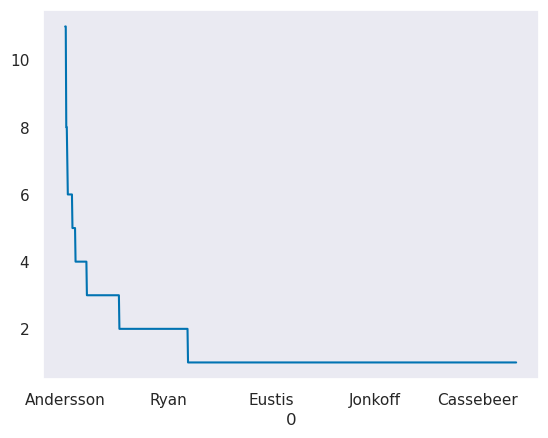

In [11]:
# Can the last name from feature name be relevant to predict 'Survived'?

print(df['Name'].str.split(',', expand=True)[0].value_counts()[0:10])
print(df[df['Name'].str.contains('Smith', na=False)])
df['Name'].str.split(',', expand=True)[0].value_counts().plot()

# It does not seem so. Most last names are single entries and repeated common names belong often to more than one family

<Axes: >

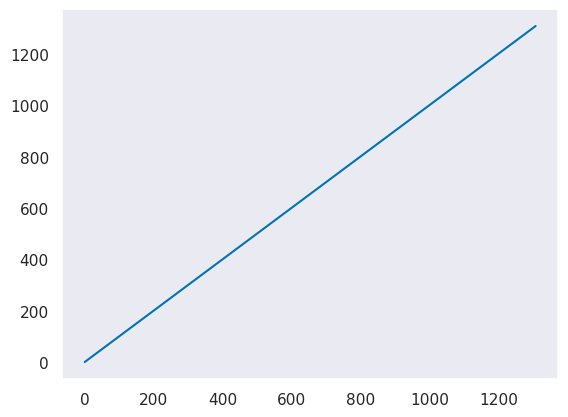

In [12]:
# Can the feature 'PassangerId' be relevant to predict 'Survived'?

df['PassengerId'].plot()

# No. Just a sequence of int

In [13]:
# Can the feature 'Ticket' be relevant to predict 'Survived'?

df['Ticket'].head(50)
df.sort_values(by='Ticket').head(50)
df.sort_values(by='Ticket').tail(50)
df[df['Ticket'].duplicated()].sort_values(by='Ticket').head(20)

# could not find a reasonable reason to keep this feature. It is a alphanumeric or numeric sequence, if repeated entries that sometimes relate to a family, but sometimes also not

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S
504,505,1.0,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S
558,559,1.0,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,S
585,586,1.0,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,E68,S
475,476,0.0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S
1127,1128,NaN,1,"Warren, Mr. Frank Manley",male,64.0,1,0,110813,75.2500,D37,C
523,524,1.0,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C
1263,1264,NaN,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0000,B52 B54 B56,S
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.4000,NaN,C
1294,1295,NaN,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S


## Actions:

### drop :
- **'Name'**: Most last names are single entries and repeated common names belong often to more than one family
- **'PassangerID'**: sequence of int starting at 1
- **'Cabin'**: have 77% missing-values
- **'Ticket'** is a alphanumeric or numeric sequence, if repeated entries sometimes relate to a family, but sometimes also not.

In [15]:
df = df.drop(['Name','PassengerId', 'Cabin', 'Ticket'], axis=1)

## Feature data types

In [17]:
feature_dict = {
    'category': ['Sex', 'Embarked'],
    'ordered_category': ['Pclass', 'SibSp', 'Parch'],
    'numeric': ['Age', 'Fare'],
    'target': ['Survived'],
    #'object': ['Cabin'],
}

#check if all columns were included
sorted(df.columns) == sorted([item for sublist in feature_dict.values() for item in sublist])


True

## Convert categorical features to category data type

In [19]:
# Convert columns to category dtype
df[feature_dict['category']] = df[feature_dict['category']].apply(pd.Categorical)

df[feature_dict['target']] = df[feature_dict['target']].apply(pd.Categorical)

# Convert columns to ordered category dtype

ordered_dict = {}

for i in feature_dict['ordered_category']:
    ordered_dict[i] = df[i].value_counts().sort_index().index.to_list()

#check
print(f'Order of the categories:\n {ordered_dict} \n')


for col in feature_dict['ordered_category']:
    df[col] = pd.Categorical(df[col], categories=ordered_dict[col], ordered=True)

del ordered_dict    

df.info()

Order of the categories:
 {'Pclass': [1, 2, 3], 'SibSp': [0, 1, 2, 3, 4, 5, 8], 'Parch': [0, 1, 2, 3, 4, 5, 6, 9]} 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    1309 non-null   category
 2   Sex       1309 non-null   category
 3   Age       1046 non-null   float64 
 4   SibSp     1309 non-null   category
 5   Parch     1309 non-null   category
 6   Fare      1308 non-null   float64 
 7   Embarked  1307 non-null   category
dtypes: category(6), float64(2)
memory usage: 29.5 KB


## Exploring the numeric features

In [21]:
df.describe()

,Age,Fare
count,1046.000000,1308.000000
mean,29.881138,33.295479
std,14.413493,51.758668
min,0.170000,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,39.000000,31.275000
max,80.000000,512.329200


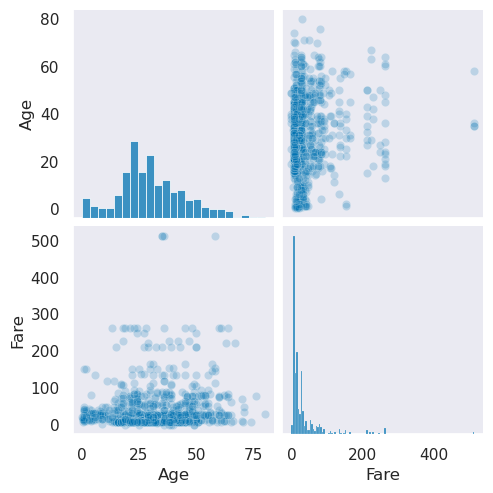

In [22]:
sns.pairplot(df,plot_kws=dict(alpha=SCATTER_ALPHA))

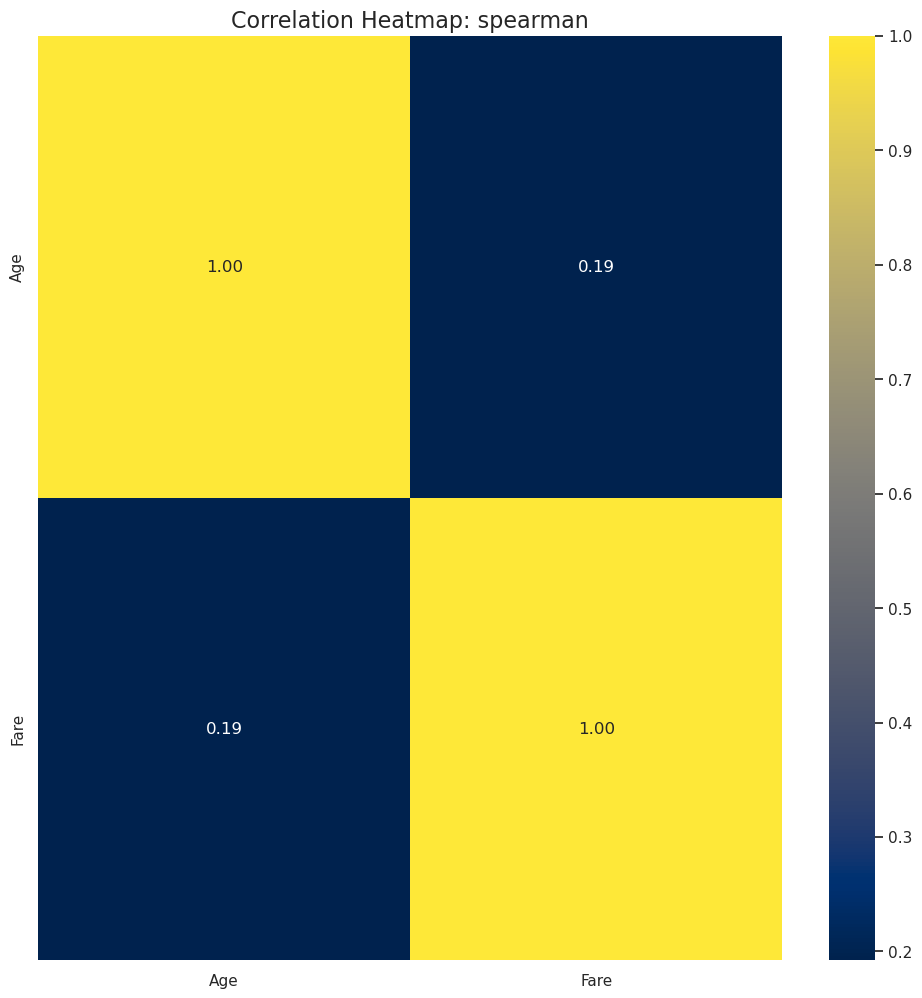

In [23]:
plot_correlation_heatmap(df, cmap=PALETTE, method='spearman')

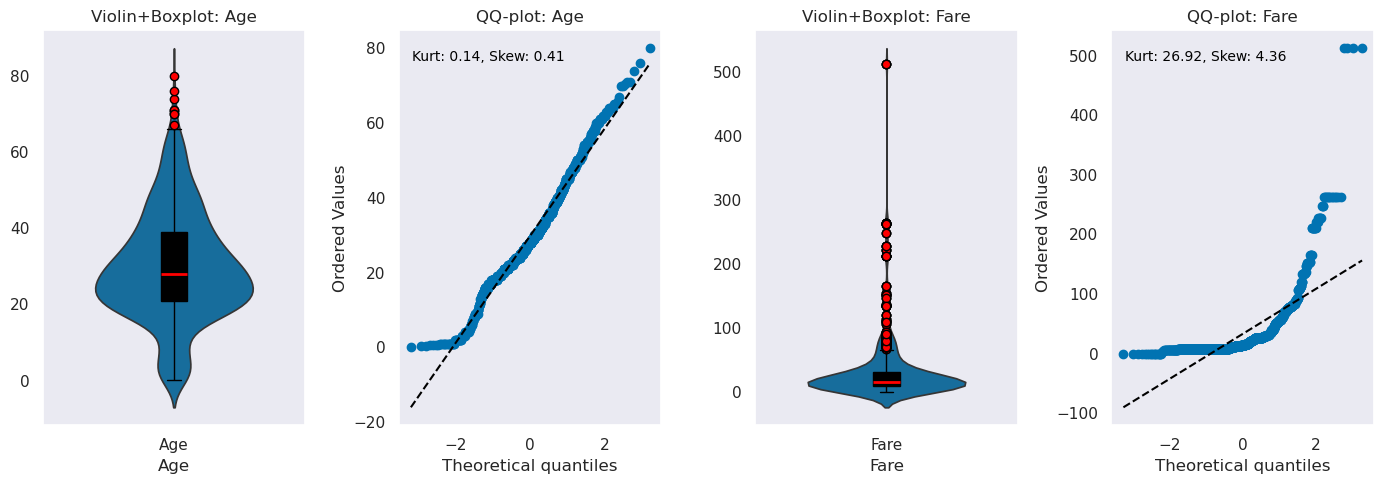

In [24]:
plot_violin_box_qq(df,n_cols_per_row=2)

## remarks:
- outliers in 'Fare' (flattened data)

/home/alexhubbe/MEGA/hashtag_data_science/machine_learning/mod_16/notebook/src/eda.py:80: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kurtosis = stats.kurtosis(sample_data)
/home/alexhubbe/MEGA/hashtag_data_science/machine_learning/mod_16/notebook/src/eda.py:81: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  skewness = stats.skew(sample_data)
/home/alexhubbe/MEGA/hashtag_data_science/machine_learning/mod_16/notebook/src/eda.py:80: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kurtosis = stats.kurtosis(sample_data)
/home/alexhubbe/MEGA/hashtag_data_science/machine_learning/mod_16/notebook/src/eda.py:81: SmallSampleWarning: One or more sample arguments is too small; all returned values will b

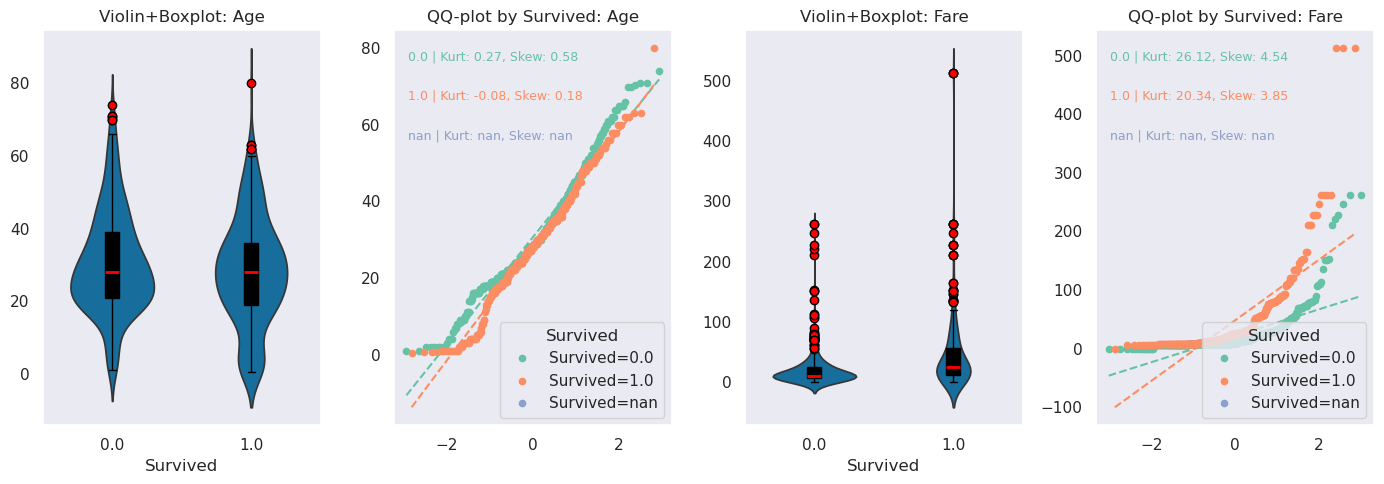

In [26]:
plot_violin_box_qq(df, cat_variable=feature_dict['target'], n_cols_per_row=2)

## Exploring the numeric vs non-numeric features

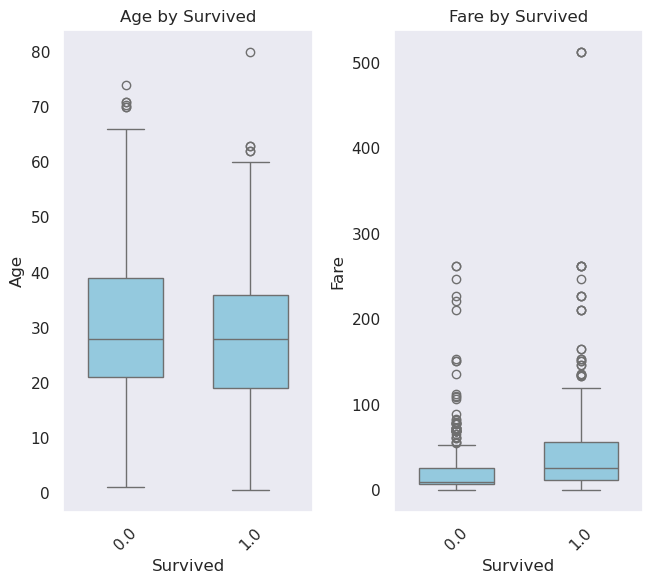

In [28]:
plot_boxplot_cat(df, feature_dict['target'], feature_dict['numeric'],ncols=3)

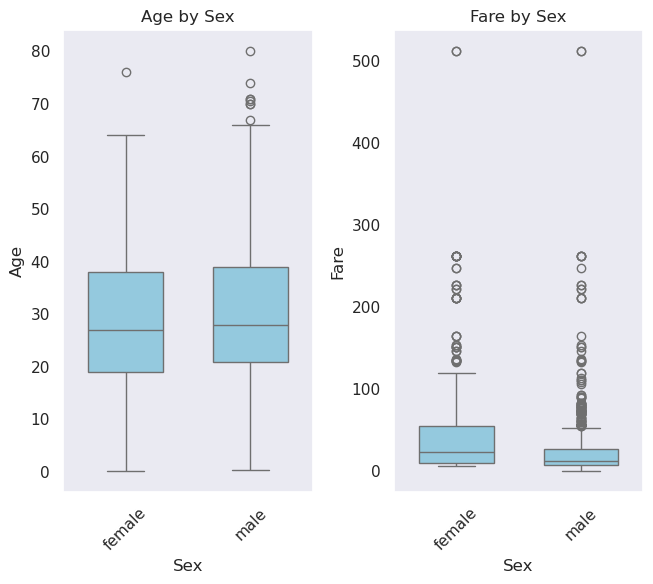

In [29]:
plot_boxplot_cat(df, 'Sex', feature_dict['numeric'],ncols=3)

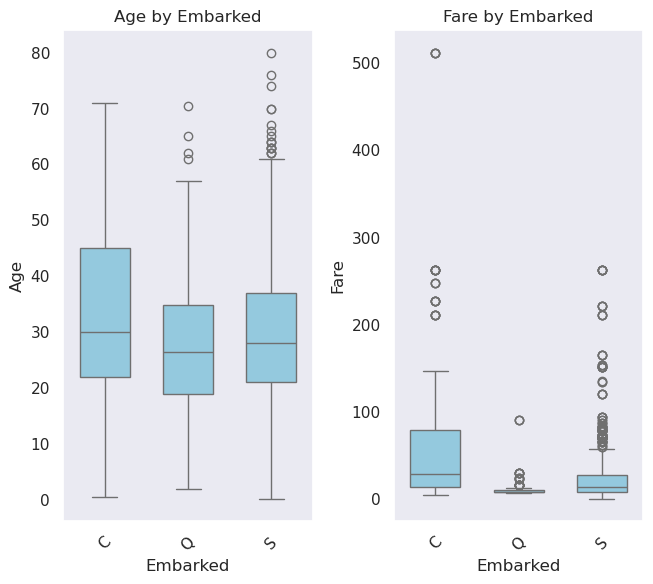

In [30]:
plot_boxplot_cat(df, 'Embarked', feature_dict['numeric'],ncols=3)

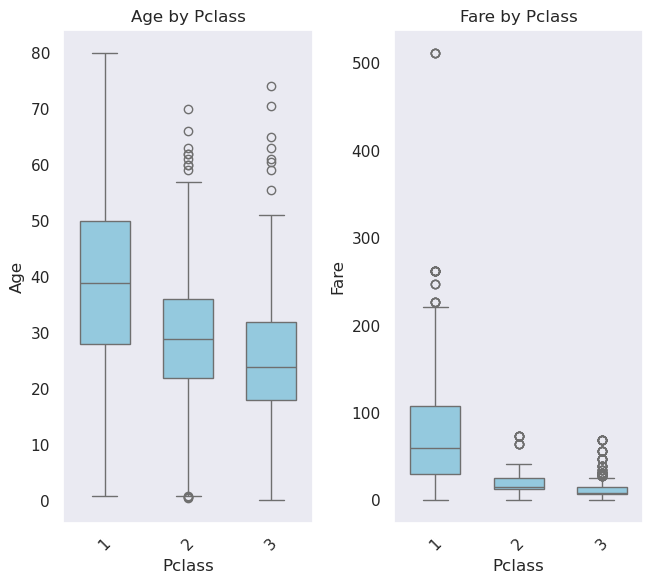

In [31]:
plot_boxplot_cat(df, 'Pclass', feature_dict['numeric'],ncols=3)

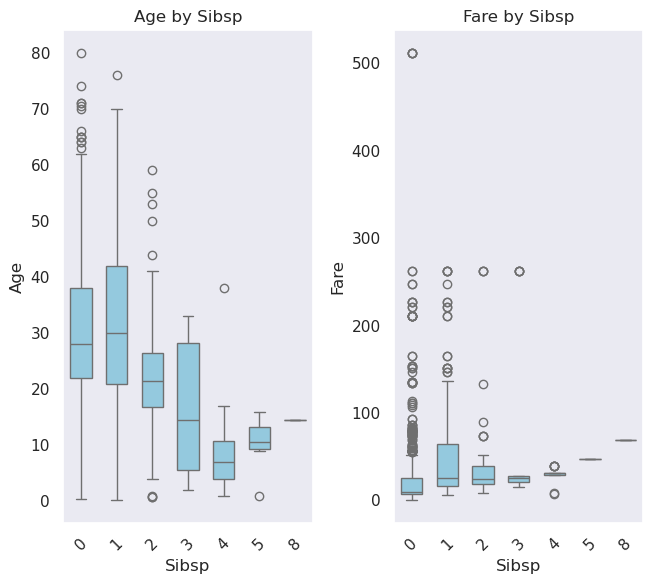

In [32]:
plot_boxplot_cat(df, 'SibSp', feature_dict['numeric'],ncols=3)

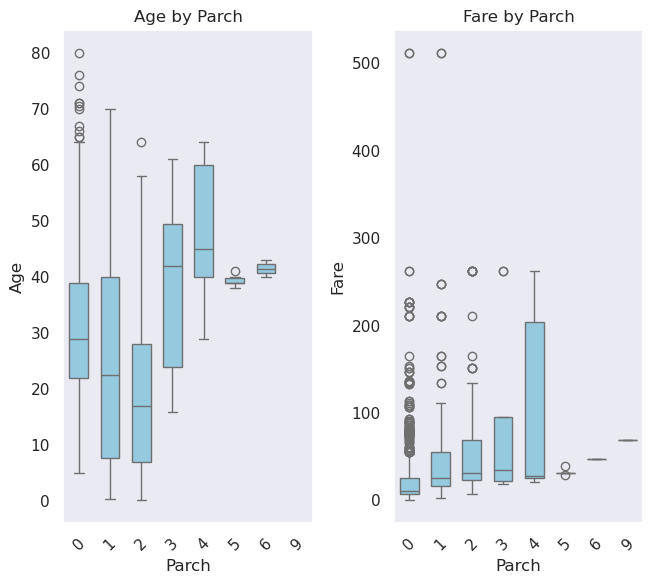

In [33]:
plot_boxplot_cat(df, 'Parch', feature_dict['numeric'],ncols=3)

## Remarks:
- Survived: bigger 'Fare' survived more?
- Sex: no drastic difference
- Pclass: first class passengers are older and the fare is more expensive
- Embarked: difference in 'Fare'?

## Initial Thoughts:
- explore outliers

## Exploring the non-numeric features

In [36]:
df.describe(exclude='number')

,Survived,Pclass,Sex,SibSp,Parch,Embarked
count,891.0,1309,1309,1309,1309,1307
unique,2.0,3,2,7,8,3
top,0.0,3,male,0,0,S
freq,549.0,709,843,891,1002,914


In [37]:
pd.crosstab(df['Survived'], [df['Sex'], df['Pclass']], margins=True, normalize='columns'
           ).round(3).style.background_gradient(cmap=PALETTE, axis="columns", vmin=0, vmax=1)

## Remarks:
- 'Sex' and 'Pclass' have an influence on 'Survived'


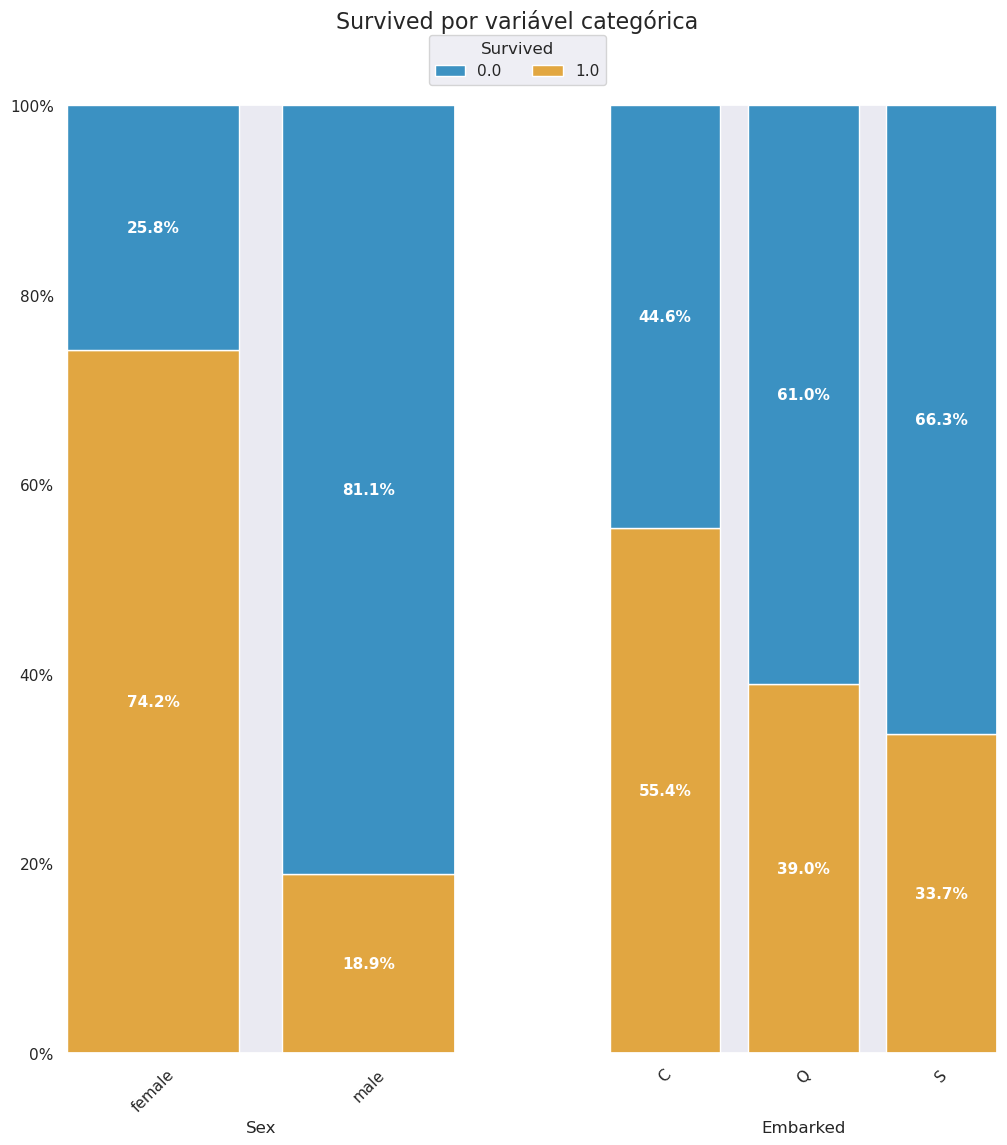

In [39]:
plot_categories_comparison(df, feature_dict['target'], feature_dict['category'], figsize=(12,12), title_distance=0.9)

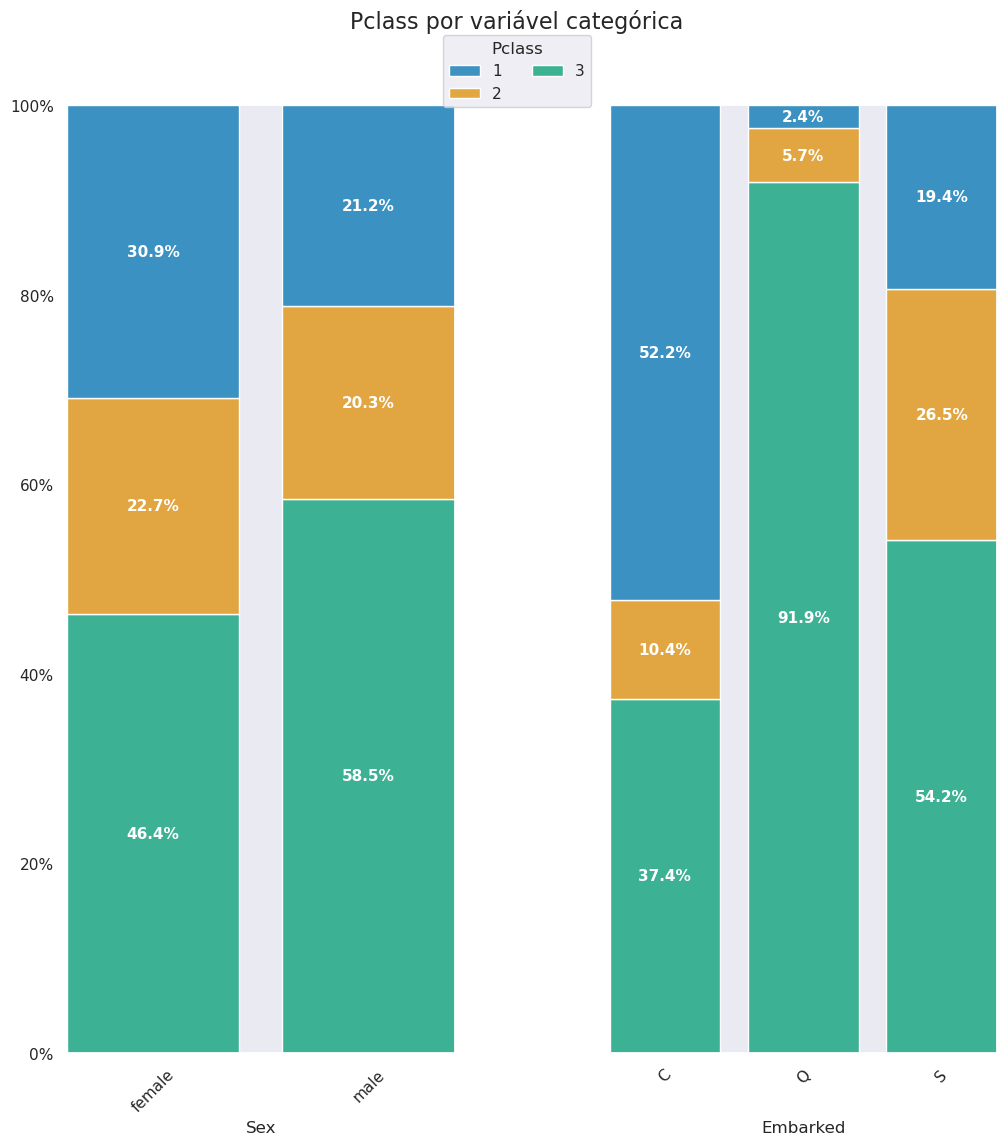

In [40]:
plot_categories_comparison(df, 'Pclass', feature_dict['category'], figsize=(12,12), title_distance=0.9)

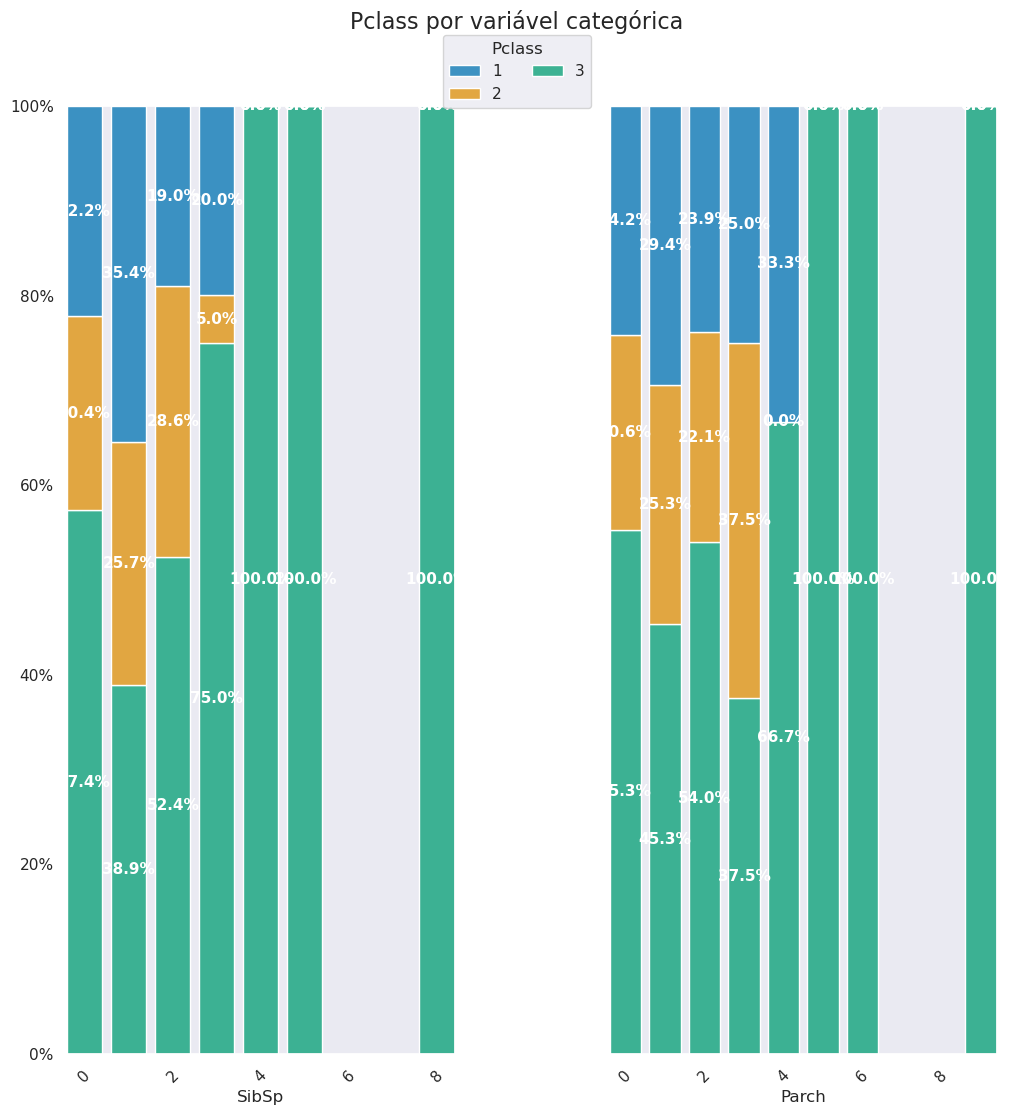

In [41]:
plot_categories_comparison(df, 'Pclass', ['SibSp','Parch'], figsize=(12,12), title_distance=0.9)

In [42]:
# SibSp and Parch as they are, are not very informative.
#create categories 0, 1, 2+ for them

df['Parch'] = df['Parch'].map(lambda x: '0' if x == 0 else '1' if x == 1 else '2+')
df['SibSp'] = df['SibSp'].map(lambda x: '0' if x == 0 else '1' if x == 1 else '2+')

ordered_dict = {}

for i in feature_dict['ordered_category']:
    ordered_dict[i] = df[i].value_counts().sort_index().index.to_list()

#check
print(f'Order of the categories:\n {ordered_dict} \n')


for col in feature_dict['ordered_category']:
    df[col] = pd.Categorical(df[col], categories=ordered_dict[col], ordered=True)

del ordered_dict    

df.info()

Order of the categories:
 {'Pclass': [1, 2, 3], 'SibSp': ['0', '1', '2+'], 'Parch': ['0', '1', '2+']} 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    1309 non-null   category
 2   Sex       1309 non-null   category
 3   Age       1046 non-null   float64 
 4   SibSp     1309 non-null   category
 5   Parch     1309 non-null   category
 6   Fare      1308 non-null   float64 
 7   Embarked  1307 non-null   category
dtypes: category(6), float64(2)
memory usage: 29.0 KB


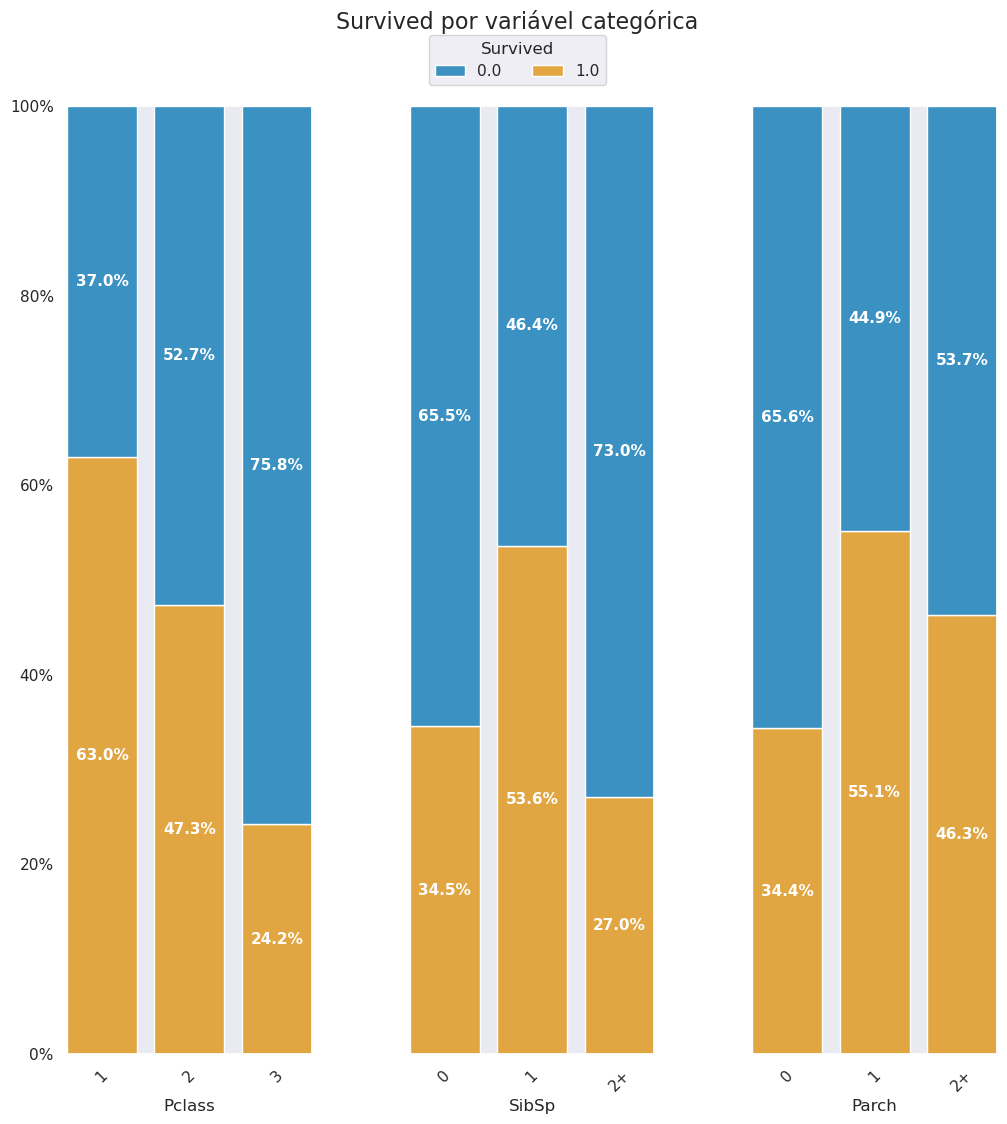

In [43]:
plot_categories_comparison(df, feature_dict['target'], feature_dict['ordered_category'], figsize=(12,12), title_distance=0.9)

In [44]:
pd.crosstab(df['Survived'], [df['SibSp'], df['Parch']], margins=True, normalize='columns'
           ).round(3).style.background_gradient(cmap=PALETTE, axis="columns", vmin=0, vmax=1)

## Remarks
- 'Sex' and 'Pclass' have an influence on 'Survived'
- 91% passengers in Q are from 3 class
- SibSp and Parch have a relation with 'Survived'
- 

# Exploring NaN

Missing values are present in 'Age', 'Fare', 'Cabin', and 'Embarked'.

In [48]:
print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0] * 100)


Columns with null values (%):
 Survived    31.932773
Age         20.091673
Fare         0.076394
Embarked     0.152788
dtype: float64


In [49]:
cross_table_NaN(df, focal_column='Embarked')


Crosstable for Survived:
Embarked    0.0    All
Survived              
0.0       0.618  0.618
1.0       0.382  0.382
All       1.000  1.000

Crosstable for Pclass:
Embarked    0.0    All
Pclass                
1         0.246  0.246
2         0.212  0.212
3         0.542  0.542
All       1.000  1.000

Crosstable for Sex:
Embarked    0.0    All
Sex                   
female    0.355  0.355
male      0.645  0.645
All       1.000  1.000

Crosstable for SibSp:
Embarked    0.0    All
SibSp                 
0         0.680  0.680
1         0.244  0.244
2+        0.076  0.076
All       1.000  1.000

Crosstable for Parch:
Embarked    0.0    All
Parch                 
0         0.765  0.765
1         0.130  0.130
2+        0.105  0.105
All       1.000  1.000

Crosstable for Embarked:
Embarked    0.0    All
Embarked              
C         0.207  0.207
Q         0.094  0.094
S         0.699  0.699
All       1.000  1.000


Processing column: Survived (dtype: category)
Binary variable (bin_var):
Survived
0    891
1    418
Name: count, dtype: int64
Numeric columns for plotting: ['Age', 'Fare']


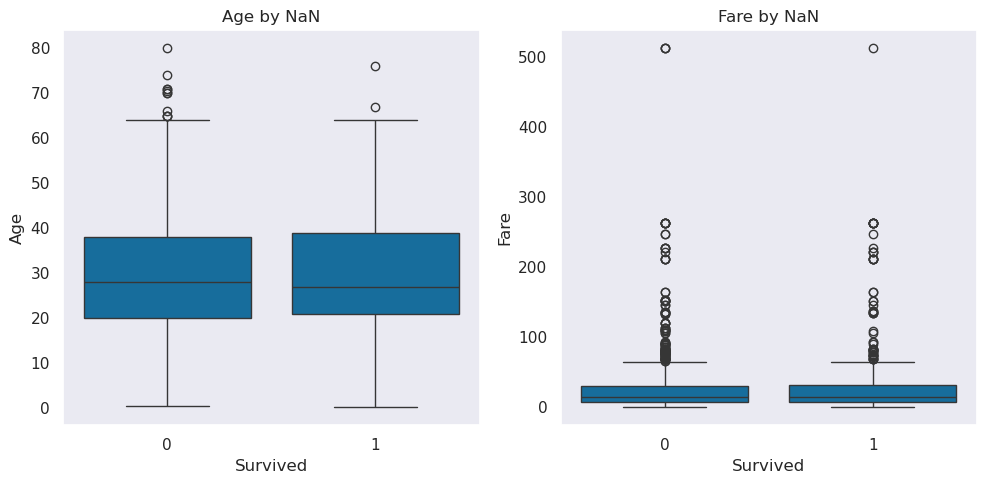

In [50]:
plot_boxplot_by_focal_variable(df,focal_column='Survived')


**Substituindo pelas média da idade**

In [52]:
# Calculando a média das idades

In [53]:
# Substituindo os valores nulos por essa média

# Outliers

<Axes: >

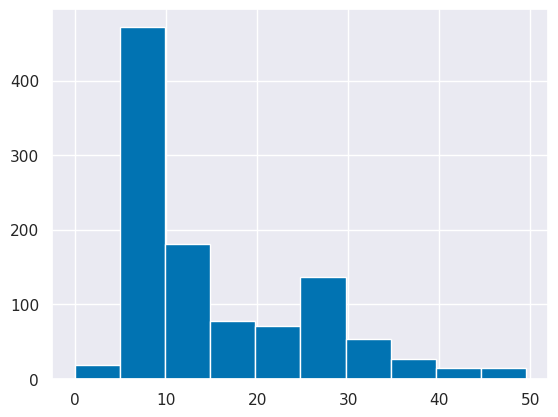

In [104]:
df[df['Fare'] > 200].groupby('Embarked', observed = False)['Fare'].agg(['mean', 'std'])

df['Fare'][df['Fare'] < 50].hist()

#df[df['Age'] > 60] 


# no reason to exclude outliers, given that they do not seem to be error imputs


# Exploring best transformations

## Size optimization

In [110]:
downcast_columns(df)
df.info()

Column: Age, All integers: False
Column: Fare, All integers: False


## Saving cleaned database

In [ ]:
df_clean.to_parquet(DADOS_LIMPOS,index=False)